# Häufigkeit der Trends in den Nachrichten (Headline, Intro)

## 1. Pre-Process für den Trends


1. Entfernen von Special-Characters
    - z.B. Johnson & Johnson => Johnson Johnson


2. Die Stoppwörter werden nicht länger berücksichtigt.
    - Begründung: Die Stoppwörter nach der Lemmatrisierung leistet keinen Beitrag bei der Aufzählung der Häufigkeiten innerhalb der Nachrichten
    
    
3. Lemmatrisierung
    - Begründung: die Nachrichten wurden ebenfalls lemmatrisiert. Darum ist es ein notwendiger Schritt, den gleichen Prozess zu befolgen.


4. Herausnehmen von 'Unique'-Werten
    - z.B. ['Johnson', 'Johnson'] => ['Johnson']

In [54]:
import cologne_phonetics
import spacy
import re
import pandas as pd
import numpy as np

nlp = spacy.load("de_core_news_sm")

In [55]:
news = pd.read_csv("data/processed/withoutStopwords/news.csv")
trends = pd.read_csv("data/raw/trends.csv")
trends.head()

,date,keyword
0,31/05/2021,DHL
1,31/05/2021,Hilli Fruits
2,31/05/2021,Commerzbank
3,31/05/2021,DAX
4,31/05/2021,Fronleichnam


In [56]:
trends["processed"] = "-"

for index, row in trends.iterrows():
    doc = nlp(re.sub('\W+',' ', row["keyword"]))
    #doc = nlp(row["keyword"])
    processed = []
    for tk in doc:
        if not tk.is_stop:
            processed.append(tk.lemma_)
    unique_processed = np.unique(np.array(processed))
    row["processed"] = unique_processed
    

trends.head()

,date,keyword,processed
0,31/05/2021,DHL,[DHL]
1,31/05/2021,Hilli Fruits,"[Fruits, Hilli]"
2,31/05/2021,Commerzbank,[Commerzbank]
3,31/05/2021,DAX,[DAX]
4,31/05/2021,Fronleichnam,[Fronleichnam]


## 2. Messung der Häufigkeiten nach den Tagen


1. Speicherung der zu erstellenden Dates-Spalten


2. Hinzufügen der neuen Dates-Spalten im Rahmen der Tage innerhalb der Web-Scraping-Periode


3. Aufzählung der Trendswörter-Erscheinung


4. Speicherung der gesamten Verarbeitungen zur manuellen Entdeckung der Probleme. (trend_news_frequency.log)


5. Speicherung des Ergebnisses in CSV

In [57]:
dates_columns = []
for i in range(1,15):
    str_num = str(i)
    day = str_num if len(str_num) == 2 else "0" + str_num
    date = f'{day}/06/2021'
    dates_columns.append(date)
    trends[date] = 0
trends.head()

,date,keyword,processed,01/06/2021,02/06/2021,03/06/2021,04/06/2021,05/06/2021,06/06/2021,07/06/2021,08/06/2021,09/06/2021,10/06/2021,11/06/2021,12/06/2021,13/06/2021,14/06/2021
0,31/05/2021,DHL,[DHL],0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,31/05/2021,Hilli Fruits,"[Fruits, Hilli]",0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31/05/2021,Commerzbank,[Commerzbank],0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,31/05/2021,DAX,[DAX],0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,31/05/2021,Fronleichnam,[Fronleichnam],0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
import os
import sys

if os.path.exists("./data/processed/frequency/trend_news_frequency.log"):
    os.remove("./data/processed/frequency/trend_news_frequency.log")
    
sys.stdout = open('./data/processed/frequency/trend_news_frequency.log', 'w')

for index_trend, row_trend in trends.iterrows():
    for index_news, row_news in news.iterrows():
        length_headline = 0
        length_intro = 0
        length_array_processed = len(row_trend["processed"])
        for word in row_trend["processed"]:
            length_headline += 1 if word in str(row_news["headline"]) else 0
            length_intro += 1 if word in str(row_news["intro"]) else 0
        if length_headline >= length_array_processed or length_intro >= length_array_processed:
                trends.loc[index_trend, row_news["date"]] += 1
                print(row_trend["date"],row_trend["processed"],row_news["date"] ,row_news["headline"],length_headline, length_intro)

trend_frequency_path = os.path.join(os.getcwd() + "/data/processed/frequency", "trends_frequency.csv")
trends.to_csv(trend_frequency_path, encoding='utf-8')
trends.head()

,date,keyword,processed,01/06/2021,02/06/2021,03/06/2021,04/06/2021,05/06/2021,06/06/2021,07/06/2021,08/06/2021,09/06/2021,10/06/2021,11/06/2021,12/06/2021,13/06/2021,14/06/2021
0,31/05/2021,DHL,[DHL],0,0,2,0,0,0,0,0,0,0,0,0,1,0
1,31/05/2021,Hilli Fruits,"[Fruits, Hilli]",0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31/05/2021,Commerzbank,[Commerzbank],1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,31/05/2021,DAX,[DAX],2,2,1,1,0,0,1,2,1,0,1,0,0,0
4,31/05/2021,Fronleichnam,[Fronleichnam],0,1,0,0,0,0,0,0,0,0,0,0,0,0


## 3. Messung der Trendswörter-Häufigkeiten nach Zeitspanne


1. Definition einer Hilfsfunktion zur Berechnung der Zeitspanne
    - z.B. 1 Tage, 0 Tage, -13 Tage etc.
    

2. Übertragung der Werte von Dates-Spalten in den Series-Index der Zeitspanne


3. Visualisierung in Plot

In [59]:
import datetime

def days_between(d1, d2):
    d1 = datetime.datetime.strptime(d1, "%d/%m/%Y")
    d2 = datetime.datetime.strptime(d2, "%d/%m/%Y")
    return (d2 - d1).days

days_between("14/06/2021","31/05/2021") # test

-14

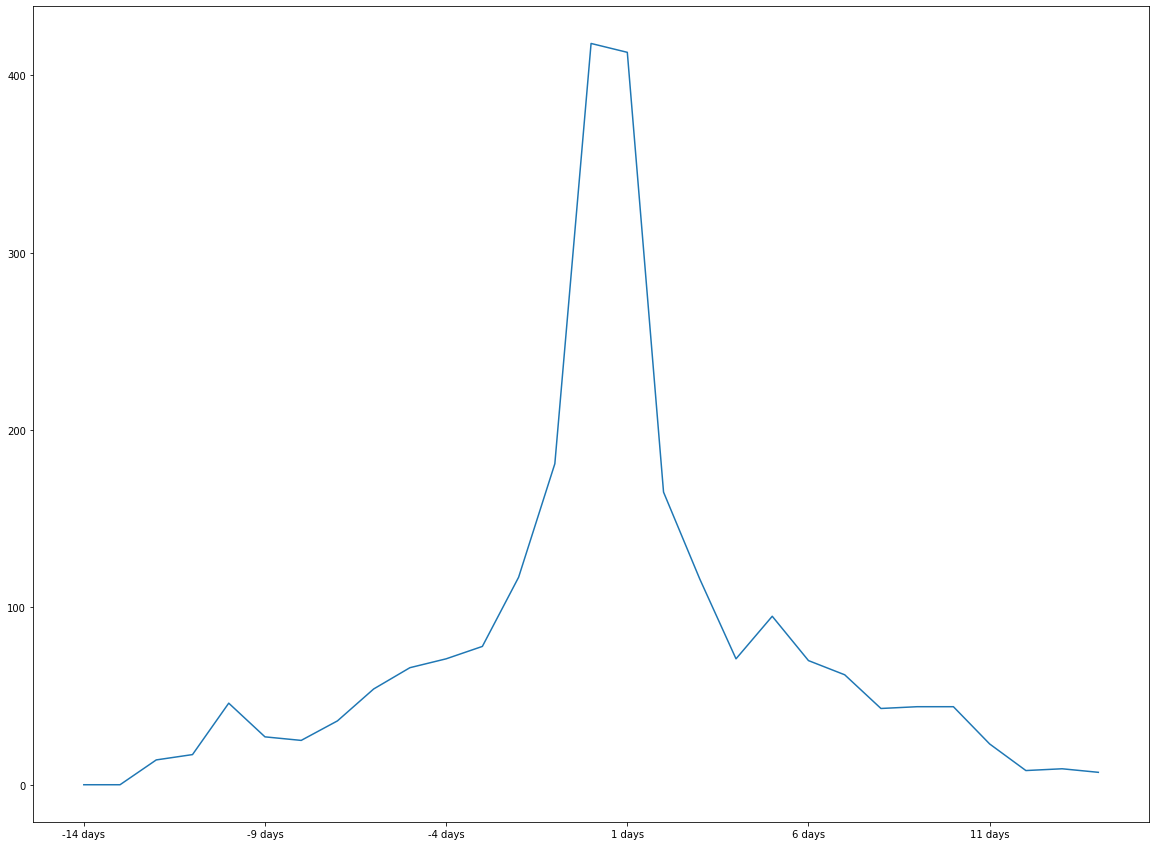

In [67]:
import matplotlib.pyplot as plt

dist_freq = pd.Series(
    data=np.zeros(14 * 2 + 1, dtype=int),
    index=np.array([f'{str(i)} days' for i in range(-14,15)])
)

for index_trend, row_trend in trends.iterrows():
    for col_date in dates_columns:
        diff_days = days_between(row_trend['date'], col_date)
        dist_freq_index = f'{str(diff_days)} days'
        dist_freq[dist_freq_index] += row_trend[col_date]

dist_freq_path = os.path.join(os.getcwd() + "/data/processed/frequency", "dist_freq.csv")
dist_freq.to_csv(dist_freq_path, encoding='utf-8')

plt.figure(figsize = (20,15))
dist_freq.plot()
plt.savefig('./visualization/plot/frequency.jpg', dpi = 50)